In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **SETUP**

In [3]:
# Test internet and install packages
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")
    
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search fastbook

print("done")

done


## Download images

Searching for 'hot dog photos'


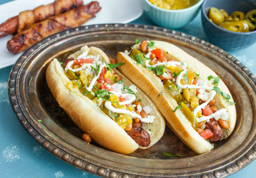

In [5]:
# from duckduckgo_search import ddg_images, DDGS
from fastcore.all import *
from fastbook import search_images_ddg
from fastdownload import download_url

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return search_images_ddg(term)

urls = search_images('hot dog photos', max_images=1)

dest = 'hot-dog.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'burger photos'


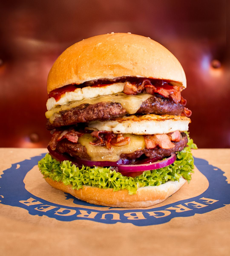

In [6]:
download_url(search_images('burger photos', max_images=1)[0], 'burger.jpg', show_progress=False)
Image.open('burger.jpg').to_thumb(256,256)

## Getting all the photos

In [8]:
searches = 'hotdog','burger'
path = Path('hotdog_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} restaurant photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} street photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'hotdog photo'
Searching for 'hotdog restaurant photo'
Searching for 'hotdog street photo'


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'burger photo'
Searching for 'burger restaurant photo'
Searching for 'burger street photo'


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Remove bad pics

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

21

## Get dataloaders

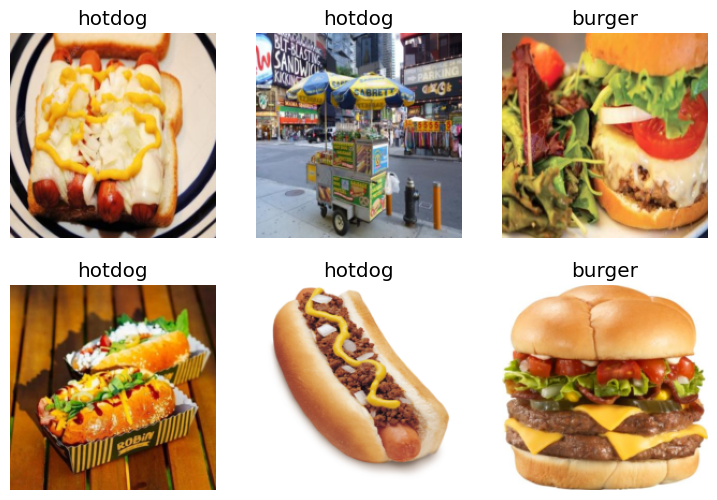

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

## Train model

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,0.678306,0.274422,0.087649,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.378030,0.267501,0.075697,01:34
1,0.223550,0.304291,0.067729,01:34
2,0.131118,0.279528,0.071713,01:34


## Use the model

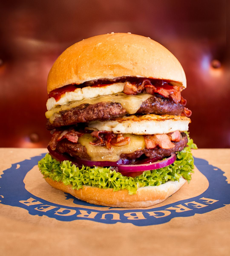

In [30]:
Image.open('./burger.jpg').to_thumb(256,256)

In [35]:
is_hotdog,_,probs = learn.predict(PILImage.create('hot-dog.jpg'))
print(f"This is a: {is_hotdog}.")
print(f"Probability it's a hotdog: {probs[1]:.4f}")

is_hotdog,_,probs = learn.predict(PILImage.create('burger.jpg'))
print(f"This is a: {is_hotdog}.")
print(f"Probability it's a burger: {probs[0]:.4f}")

This is a: hotdog.
Probability it's a hotdog: 0.9998
tensor([1.8307e-04, 9.9982e-01])


This is a: burger.
Probability it's a burger: 1.0000
